# VIT - Tensorized Version 2.2.1 - Training a classifier

-  w1 w2 w3

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# !pip install einops
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

from tqdm import tqdm
import time

# !pip install tensorly
# import tensorly
# !pip install tensorly-torch
# import tltorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Patch Embedding Class

process :

- input B C H W
- B C H W --> B p1 p2 h w c
  - where h = H/patch_size , w = W/ patch_size
  - and p1, p2 = patch index
- output B p1 p2 h w c

In [2]:
class PatchEmbedding_Tensorized(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dims, out_channels):
        super(PatchEmbedding_Tensorized, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dims = embed_dims
        self.out_channels = out_channels
        self.in_channels = in_channels

        self.w_h = nn.Parameter(torch.randn(self.patch_size, self.embed_dims[0]), requires_grad=True)
        self.w_w = nn.Parameter(torch.randn(self.patch_size, self.embed_dims[1]), requires_grad=True)
        self.w_c = nn.Parameter(torch.randn(self.in_channels, self.out_channels), requires_grad=True)

    def forward(self, x):
        # batch_size, channels, height, width = x.shape
        x = rearrange(x, 'b c (p1 h) (p2 w) -> b p1 p2 h w c', h=self.patch_size, w=self.patch_size) # X = [B P1 P2 H W C]
        x = torch.einsum('b p q h w c , h x , w y , c z  -> b p q x y z', (x, self.w_h, self.w_w, self.w_c))
        return x # patches

In [3]:
# Example
dummy_input = torch.randn(64, 3, 224, 224)
embed = PatchEmbedding_Tensorized(224, 16, 3, (16,16), 3)
embedded = embed(dummy_input)
print(f'output shape of patch embedding : {embedded.shape}')
print(f'number of patch embedding parameters is : {sum(p.numel() for p in embed.parameters() if p.requires_grad)}')

output shape of patch embedding : torch.Size([64, 14, 14, 16, 16, 3])
number of patch embedding parameters is : 521


# Multi Head Attention

process :

- input B P P H W C
- q = linear projection of input to H1 W1 C1 = B P P H1 W1 C1
- k = linear projection of input to H1 W1 C1 = B P P H1 W1 C1
- v = linear projection of input to H1 W1 C1 = B P P H1 W1 C1
- Multi head :
  - Q = B P P H1 W1 C1 ---> B P P h1 h2 h3 H2 W2 C2 where h1, h2, h3 are the number of heads and H2 is the head-h1 dimension which is H1/h1 and the same for W2 and C1
  - K = B P P H1 W1 C1 ---> B P P h H2 W2 C1 where h1, h2, h3 are the number of heads and H2 is the head-h1 dimension which is H1/h1 and the same for W2 and C1
  - V = B P P H1 W1 C1 ---> B P P h H2 W2 C1 where h1, h2, h3 are the number of heads and H2 is the head-h1 dimension which is H1/h1 and the same for W2 and C1

- Q*K -> B h P P P P  (multiplication on H2 W2 C2 of Q and K)
- scaled and softmaxed
- *V -> B h1 h2 h3 P P P H2 W2 C2
-  Rearranged to B h1 h2 h3 P P P H2 W2 C2 --> B P P P H1 W1 C1  


In [4]:
class MultiHeadAttention_Tensorzied(nn.Module):
    def __init__(self, embed_dims, h1,h2,h3):
        super(MultiHeadAttention_Tensorzied, self).__init__()
        self.embed_dims = embed_dims
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3

        # first dim is the dimension of embedded x second dim is the embedded dimension of q/k/v (could be different)
        #  Q
        self.w_e1_q = nn.Parameter(torch.randn(self.embed_dims[0], self.embed_dims[0]), requires_grad=True)
        self.w_e2_q = nn.Parameter(torch.randn(self.embed_dims[1], self.embed_dims[1]), requires_grad=True)
        self.w_e3_q = nn.Parameter(torch.randn(self.embed_dims[2], self.embed_dims[2]), requires_grad=True)

        # K
        self.w_e1_k = nn.Parameter(torch.randn(self.embed_dims[0], self.embed_dims[0]), requires_grad=True)
        self.w_e2_k = nn.Parameter(torch.randn(self.embed_dims[1], self.embed_dims[1]), requires_grad=True)
        self.w_e3_k = nn.Parameter(torch.randn(self.embed_dims[2], self.embed_dims[2]), requires_grad=True)

        # V
        self.w_e1_v = nn.Parameter(torch.randn(self.embed_dims[0], self.embed_dims[0]), requires_grad=True)
        self.w_e2_v = nn.Parameter(torch.randn(self.embed_dims[1], self.embed_dims[1]), requires_grad=True)
        self.w_e3_v = nn.Parameter(torch.randn(self.embed_dims[2], self.embed_dims[2]), requires_grad=True)



    def forward(self, x):
        q = torch.einsum('b p q h w c , h x , w y , c z -> b p q x y z', (x, self.w_e1_q, self.w_e2_q, self.w_e3_q))
        k = torch.einsum('b p q h w c , h x , w y , c z -> b p q x y z', (x, self.w_e1_k, self.w_e2_k, self.w_e3_k))
        v = torch.einsum('b p q h w c , h x , w y , c z -> b p q x y z', (x, self.w_e1_v, self.w_e2_v, self.w_e3_v))

        Q = rearrange(q, 'b p1 p2 (x h1) (y h2) (z h3) -> b p1 p2 h1 h2 h3 x y z', h1 = self.h1, h2 = self.h2, h3 = self.h3)
        K = rearrange(q, 'b p1 p2 (x h1) (y h2) (z h3) -> b p1 p2 h1 h2 h3 x y z', h1 = self.h1, h2 = self.h2, h3 = self.h3)
        V = rearrange(q, 'b p1 p2 (x h1) (y h2) (z h3) -> b p1 p2 h1 h2 h3 x y z', h1 = self.h1, h2 = self.h2, h3 = self.h3)


        # Attention calculation
        each_head_shape = Q[0][0][0][0][0][0].shape
        scale = (each_head_shape[0]*each_head_shape[1]*each_head_shape[2]) ** -0.5
        attn = torch.einsum('b p q d e f x y z,b m n d e f x y z -> b d e f p q m n', Q, K) * scale

        attention = F.softmax(attn, dim=-1)/(attn.shape[5]* attn.shape[6] * attn.shape[7] ) # divided to make the sum of each row equal to 1
        x = torch.einsum('b d e f p q m n , b m n d e f x y z -> b d e f p q x y z ', attention, V)
        x = rearrange(x, 'b h1 h2 h3 p1 p2 x y z  -> b p1 p2 (x h1) (y h2) (z h3)', h1 = self.h1, h2 = self.h2, h3 = self.h3)

        return x

In [5]:
# which softmax dim to use and how to use
def f(x):
    flag = 1
    for i in range(4):
        for j in range(5):
            for k in range(2):
                for n in range(2):
                    if np.abs(x[i][j][k][n].sum() - 1 ) >= 0.1:
                       print(x[i][j][k][n].sum(), f"{i},{j},{k},{n}")
                       flag = 0
    if flag:
       print('Correct')
r = torch.rand(4,5,6,7,4,5,4,4)
tt = F.softmax(r,dim = -1)/(r.shape[5] * r.shape[6] * r.shape[7])
f(tt)

Correct


In [6]:
# Example of usage
MHA = MultiHeadAttention_Tensorzied((16,16,3), 2,2,1)
result_mha = MHA(embedded)
print(f'MHA output shape is : {result_mha.shape}')
print(f'Input of MHA shape was : {embedded.shape}')
print(f'Number of MHA parameter is : {sum(p.numel() for p in MHA.parameters() if p.requires_grad)}')

MHA output shape is : torch.Size([64, 14, 14, 16, 16, 3])
Input of MHA shape was : torch.Size([64, 14, 14, 16, 16, 3])
Number of MHA parameter is : 1563


# Transformers Block (Encode Blocks)

process :

- define the attention block (Tensorized)
- define the mlp block ( flatten before )
  - two layers / GELU activation function
  - from embedded dimension (output of attention) to mlp dim  
  - and from mlp dim to embedded dimension (output of mlp usually the same as embed_dim)
- define layer norm

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dims, heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.heads = heads
        self.attention = MultiHeadAttention_Tensorzied(embed_dims, self.heads[0], self.heads[1], self.heads[2])
        self.norm1 = nn.LayerNorm(embed_dims)
        embed_dim = embed_dims[0]*embed_dims[1]*embed_dims[2]
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_res = x
        x = self.norm1(x + self.dropout(self.attention(x)))
        shapes = x.shape
        x = rearrange(x, 'b p1 p2 h w c -> b (p1 p2) (h w c)')
        x = self.norm2(x + self.dropout(self.mlp(x)))
        x = rearrange(x, 'b (p1 p2) (h w c) -> b p1 p2 h w c', p1 = shapes[1], p2 = shapes[2], h = shapes[3], w = shapes[4], c = shapes[5])
        return x + x_res

In [8]:
# Example of usage

dummy_input = torch.randn(16, 3, 224, 224)
embed = PatchEmbedding_Tensorized(224, 16, 3, (16,16), 3)(dummy_input)
print(f'output shape of patch embedding : {embed.shape}')

block = TransformerBlock(embed_dims = (16,16,3), heads = (2,2,1), mlp_dim = 16*16*3) #16*16*3 = 768
result_block = block(embed)
print(f'output of tensor block shape is : {result_block.shape}')
print(f'number of parameters for each block of transformer : {sum(p.numel() for p in block.parameters())}')

output shape of patch embedding : torch.Size([16, 14, 14, 16, 16, 3])
output of tensor block shape is : torch.Size([16, 14, 14, 16, 16, 3])
number of parameters for each block of transformer : 1185819


# Vision Transformer

process :

- img_size is the size of the image
- patch size is the size of the patches
- in_channels is the number of input image channels
- num_classes is the number of classes
- embed_dim is the embedding dimension (for simplification we consider it to be equal in many layers) - equal for both dim 1 and dim 2 of the tensor B H W C
- out channels  is the out channels of embedded tensor
- num_heads is the number of heads
- num_layers is the number of encode/transformer blocks
- mlp_dim is the hidden dimension of the mlp block
- dropout is the drop out rate


pos embedding :

- parameter added to the embedding patches
- input tensor is B P1 P2 H W C  ,
- pos embed shape is 1 P1 P2 H W C
- simply add it to the input tensor / pytorch will broadcast it to all batches

cls_token :

- learnable parameters, a single learned embedding representing global information about the entire image.
- input tensor is B P1 P2 H W C ,
- cls token parameter is 1 1 1 H W C
- use cls zero , padded cls token with the shape 1 1 P2 H W C where (1,1,1,:,:,:) is the cls token
- expand cls token to replicate for all batches
- cls token shape is B 1 P2 H W C 
- concat with input tensor on dim 1 (P1 - > P1+1)
- result is B P1+1 P2 H W C



classification :

- different methods
- google research simple vit uses cls token (learned) to classify images



In [9]:
# Example of CLS token as well as positional Embedding  and Patch Embedding
img_size = 224
patch_size = 16
in_channels = 3
embed_dim = 16
out_channels = 3

dummy_input = torch.randn(64, 3, 224, 224)

patch_embedding = PatchEmbedding_Tensorized(img_size, patch_size, in_channels, (embed_dim,embed_dim), out_channels)
pos_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size), (img_size // patch_size), embed_dim, embed_dim, out_channels))
cls_token = nn.Parameter(torch.randn(1, 1, 1, embed_dim, embed_dim, out_channels))



patches = patch_embedding(dummy_input)
patches += pos_embedding

print(f'input shape {dummy_input.shape}')
print(f'pos_embedding shape {pos_embedding.shape}')
print(f'patches shape {patches.shape}')

tensor_cls = torch.zeros((patches.shape[0], 1, patches.shape[2],  patches.shape[3],  patches.shape[4],  patches.shape[5]))

tensor_cls[:, 0, 0 ,:,:,:] = cls_token

new_data = torch.cat([tensor_cls, patches ], dim = 1 )

print(f'new data shape after tensor cls and expansion {new_data.shape}')

# print(f'cls data is at [63,14,0,:,:,:] which is {new_data[63,0,0,:,:,:]}')
# print(f'and the zeros are at [63,14,0:, :, :, :] which are {new_data[63,0,0:,:,:,:]}')
# print(f'the actual data is at [:,:14,:,:,:] which are {new_data[:,:14,:,:,:]}')



input shape torch.Size([64, 3, 224, 224])
pos_embedding shape torch.Size([1, 14, 14, 16, 16, 3])
patches shape torch.Size([64, 14, 14, 16, 16, 3])
new data shape after tensor cls and expansion torch.Size([64, 15, 14, 16, 16, 3])


In [10]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_channels=3,
                 num_classes=1000,
                 embed_dim= 16,
                 out_channels = 3,
                 heads=(2,2,1),
                 num_layers=12,
                 mlp_dim=16*16*3,
                 dropout=0.1
                 ):
        super(VisionTransformer, self).__init__()
        
        
        
        self.patch_embedding = PatchEmbedding_Tensorized(img_size, patch_size, in_channels, (embed_dim,embed_dim), out_channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size), (img_size // patch_size), embed_dim, embed_dim, out_channels))

        self.cls_token = nn.Parameter(torch.randn(1, 1, 1, embed_dim, embed_dim, out_channels))

        self.transformer = nn.ModuleList([
            TransformerBlock((embed_dim,embed_dim,out_channels), heads, mlp_dim, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm((embed_dim, embed_dim, out_channels))
        # embed layer is the output of final mlp layer in the transformer block
        self.fc = nn.Linear(embed_dim*embed_dim*out_channels, num_classes)

    def forward(self, x):
        patches = self.patch_embedding(x)

        patches += self.pos_embedding

        ## cls token addon        
        tensor_cls = torch.zeros((patches.shape[0],
                                  1,
                                  patches.shape[2],
                                  patches.shape[3],
                                  patches.shape[4],
                                  patches.shape[5]))

        tensor_cls[:, 0, 0 ,:,:,:] = cls_token

        x = torch.cat([tensor_cls, patches ], dim = 1 )
        
        for transformer_block in self.transformer:
            x = transformer_block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0, 0, :,:,:]
        # flatten the token to feed into mlp
        cls_token_final_vec = cls_token_final.flatten().reshape(x.shape[0],-1)
        output = self.fc(cls_token_final_vec)
        return output


## Example

In [13]:
vit = VisionTransformer(img_size=224, patch_size=16, in_channels=3, num_classes=10)

# dummy_input = torch.randn(6, 3, 224, 224)
# output = vit(dummy_input)
# print(output.shape)

print(f'total number of parameters : {sum(p.numel() for p in vit.parameters())}')

total number of parameters : 14390871


# Training a classifier

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Load Dataset CIFAR10

100%|██████████| 170498071/170498071 [00:04<00:00, 41518444.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


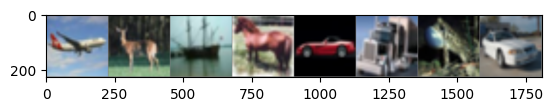

plane deer  ship  horse car   truck frog  car  
images size is : torch.Size([8, 3, 224, 224])


In [ ]:
transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(f'images size is : {images.shape}')

## Optimizer and Criterion and model

In [ ]:
vit = VisionTransformer(img_size=224, patch_size=16, in_channels=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters())


num_parameters = sum(p.numel() for p in vit.parameters() if p.requires_grad)

print(f'number of parameters : {num_parameters}')

number of parameters : 78718474


## Train/Test functions

In [ ]:
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    vit.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = vit(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.shape[0]
        correct += predicted.eq(targets).sum().item()


    acc = 100.*correct/total
    # print(f'acc : {acc}')

    return train_loss/(batch_idx+1), acc # train loss mean over all batches (batches start from 0)

def test(epoch):
    vit.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vit(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    acc = 100.*correct/total
    # print(f'acc : {acc}')

    return test_loss/(batch_idx+1), acc

# Train/Test the model

In [ ]:
n_epochs = 200

train_list_loss = []
train_list_acc = []

test_list_loss = []
test_list_acc = []

best_acc_train = 0
best_acc_test= 0

progress_bar = tqdm(total=n_epochs, desc='Training Progress', position=0)


for epoch in range(0, n_epochs):
    start = time.time()
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    train_list_loss.append(train_loss)
    train_list_acc.append(train_acc)

    test_list_loss.append(test_loss)
    test_list_acc.append(test_acc)

    if test_acc > best_acc_test:
        best_acc_test = test_acc

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    tqdm_dict = {
        'Train Loss': train_loss,
        'Test Loss': test_loss,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Best Train Acc': best_acc_train,
        'Best Test Acc': best_acc_test,
        'Epoch Time': time.time() - start,
    }

    progress_bar.set_postfix(tqdm_dict)
    progress_bar.set_description(f"Epoch {epoch}/{n_epochs}")


    progress_bar.update(1)


progress_bar.close()
